In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import itertools
# import higherOrderKME
# from higherOrderKME import sigkernel
import Path_Char
from Path_Char.path_characteristic_function import char_func_path
from Path_Char.high_order_pcf import PCFKernel
from torch.utils.data import DataLoader

# Using seaborn's style
plt.style.use('seaborn-colorblind')
width = 345
tex_fonts = {
    "text.usetex": False,  # put False if this raises errors
    "font.family": "serif",
    "axes.labelsize": 24,
    "font.size": 22,
    "legend.fontsize": 24,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    'figure.figsize': (7, 5),
}
plt.rcParams.update(tex_fonts)
torch.manual_seed(0)

In [2]:
device = 'cuda'

In [22]:
# number of path coordinates and number of time steps
D, L = 1, 3 

# experimental setup
repeats, n_samples, n, lambda_ = 1000, 500, 5*1e5, 1e-5

MMD_1 = np.zeros((repeats, 2))
MMD_2 = np.zeros((repeats, 2))

# to store the sample paths from X_n and X
X = np.zeros((repeats, n_samples, 2, L, D)) 
X_n = np.zeros((repeats, n_samples, 2, L, D))   

# sample from X_n 
omega_1 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
omega_2 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
X_n[:, :, :, 1, 0] = omega_1 * 1./n
X_n[:, :, :, 2, 0] = 0.1 * omega_1

# sample from X
omega_1 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
X[:, :, :, 2, 0] = 0.1 * omega_1

In [5]:
lie_degree_1 = 4
num_samples_1 = 20
input_size = 1
add_time = False

pcf_level_1 = char_func_path(num_samples=num_samples_1, 
                              hidden_size=lie_degree_1, 
                              input_dim=input_size, 
                              add_time=add_time, 
                              include_initial = False)
pcf_level_1.to(device)

num_samples_2 = 100
lie_degree_2 = 4
pcf_level_2 = char_func_path(num_samples=num_samples_2, 
                              hidden_size=lie_degree_2, 
                              input_dim=lie_degree_1**2, 
                              add_time=add_time, 
                              include_initial = False)
pcf_level_2.to(device)

char_func_path(
  (unitary_development): development_layer(
    (projection): projection(
      (param_map): unitary()
    )
  )
)

In [7]:
kernel_order1 = PCFKernel(pcf_level_1)
kernel_order2 = PCFKernel([pcf_level_1, pcf_level_2])

In [9]:
for i in tqdm(range(repeats)):

    x0 = torch.tensor(X[i, :, 0, :, :], dtype=torch.float64).to(device)     # X of shape (repeats,n_samples,2,L,D)
    x0_ = torch.tensor(X[i, :, 1, :, :], dtype=torch.float64).to(device)    # independent copy of X
    xn = torch.tensor(X_n[i, :, 0, :, :], dtype=torch.float64).to(device)
    xn_ = torch.tensor(X_n[i, :, 1, :, :], dtype=torch.float64).to(device)  # independent copy of X_n

    MMD_2[i,0] = kernel_order2.compute_mmd(x0, x0_, order=2)   
    MMD_2[i,1] = kernel_order2.compute_mmd(xn, x0, order=2)   
    
    MMD_1[i,0] = kernel_order1.compute_mmd(x0, x0_, order=1)   
    MMD_1[i,1] = kernel_order1.compute_mmd(xn, x0, order=1)   

  0%|          | 0/100 [00:00<?, ?it/s]

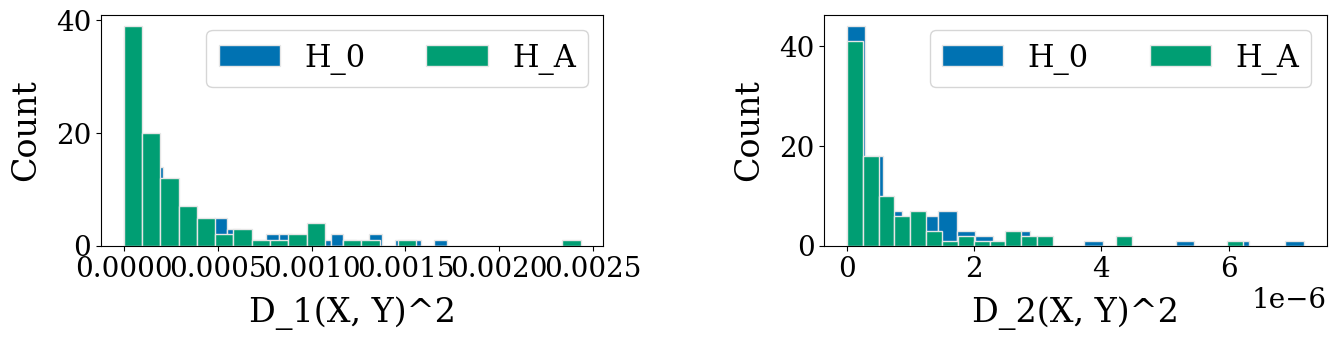

In [10]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].hist(MMD_1[:,0], bins=25, label='H_0',edgecolor='#E6E6E6')
ax[0].hist(MMD_1[:,1], bins=25, label='H_A',edgecolor='#E6E6E6')

ax[0].legend(loc='upper right', ncol=2, fontsize=22)
ax[0].set_xlabel('D_1(X, Y)^2', labelpad=10)
ax[0].set_ylabel('Count', labelpad=10)

ax[1].hist(MMD_2[:,0], bins=25, label='H_0', edgecolor='#E6E6E6')
ax[1].hist(MMD_2[:,1], bins=25, label='H_A', edgecolor='#E6E6E6')

ax[1].legend(loc='upper right', ncol=2, fontsize=22)
ax[1].set_xlabel('D_2(X, Y)^2', labelpad=10)
ax[1].set_ylabel('Count', labelpad=10)

plt.tight_layout(pad=3.0)
# plt.savefig('MMD_binary_tex.pdf',bbox_inches='tight')
plt.show()

In [30]:
def HS_norm(X: torch.tensor, Y: torch.Tensor):
    """_summary_

    Args:
        X (torch.Tensor): (C,m,m) complexed valued
    """
    if len(X.shape) == 4:

        m = X.shape[-1]
        X = X.reshape(-1, m, m)

    else:
        pass
    D = torch.bmm(X, torch.conj(Y).permute(0, 2, 1))
    return ((torch.einsum('bii->b', D)).mean().real)

In [115]:
torch.manual_seed(0)
# 0,0,0.1
x001 = torch.tensor(X[0, 2:3, 0, :, :], dtype=torch.float64).to(device)

# 0,0,-0,1
x00_1 = torch.tensor(X[0, :1, 0, :, :], dtype=torch.float64).to(device)

dv_x001 = pcf_level_1.unitary_development(x001)
dv_x00_1 = pcf_level_1.unitary_development(x00_1)

In [116]:
X[0, 2:3, 0, :, :]

array([[[0. ],
        [0. ],
        [0.1]]])

In [117]:
X[0, :1, 0, :, :]

array([[[ 0. ],
        [ 0. ],
        [-0.1]]])

In [141]:
X.shape

(100, 500, 2, 3, 1)

In [129]:
torch.manual_seed(0)
# 0,1/n, 0.1
xn001 = torch.tensor(X_n[0, 1:2, 0, :, :], dtype=torch.float64).to(device)

# 0,-1/n, -0.1
xn00_1 = torch.tensor(X_n[0, 2:3, 0, :, :], dtype=torch.float64).to(device)

dv_xn001 = pcf_level_1.unitary_development(xn001)
dv_xn00_1 = pcf_level_1.unitary_development(xn00_1)

In [130]:
xn001

tensor([[[0.0000e+00],
         [2.0000e-06],
         [1.0000e-01]]], device='cuda:0', dtype=torch.float64)

In [131]:
xn00_1

tensor([[[ 0.0000e+00],
         [-2.0000e-06],
         [-1.0000e-01]]], device='cuda:0', dtype=torch.float64)

In [101]:
dv_xn001 - dv_xn00_1

tensor([[[[ 5.9605e-08-1.6184e-01j,  2.9695e-02+3.9046e-02j,
            9.8898e-02+8.7134e-02j,  7.5324e-02+1.0056e-01j],
          [-2.9695e-02+3.9046e-02j,  0.0000e+00-6.1022e-02j,
           -3.1189e-02-1.1996e-01j,  2.3694e-02-5.3792e-02j],
          [-9.8898e-02+8.7134e-02j,  3.1189e-02-1.1996e-01j,
            0.0000e+00+9.8305e-02j,  1.5616e-01-1.2707e-01j],
          [-7.5324e-02+1.0056e-01j, -2.3694e-02-5.3792e-02j,
           -1.5616e-01-1.2707e-01j,  0.0000e+00-2.9618e-01j]],

         [[ 0.0000e+00-1.7823e-01j,  1.9169e-02-3.6098e-02j,
           -1.4491e-02-1.1527e-01j, -2.8017e-02-1.9584e-02j],
          [-1.9169e-02-3.6098e-02j,  5.9605e-08+4.2943e-02j,
           -8.7971e-02-1.3185e-01j,  1.1486e-01+2.0562e-01j],
          [ 1.4491e-02-1.1527e-01j,  8.7971e-02-1.3185e-01j,
            0.0000e+00+1.7394e-01j,  5.7361e-02-8.5639e-02j],
          [ 2.8017e-02-1.9584e-02j, -1.1486e-01+2.0562e-01j,
           -5.7361e-02-8.5639e-02j,  0.0000e+00-3.5238e-02j]],

         [[ 

In [147]:
def experiment(pcf_1, pcf_2, X, X_n):
    repeats = X.shape[0]
    batch_X = X.shape[1]
    T = X.shape[-2]
    num_samples_1 = pcf_level_1.num_samples
    
    MMD_1 = np.zeros((repeats, 2))
    MMD_2 = np.zeros((repeats, 2))
    for i in tqdm(range(repeats)):
        
        expected_dev_x0 = torch.zeros([500, num_samples_1, 3, 4,4]).to(device).to(torch.cfloat) 
        expected_dev_x0_ = torch.zeros([500, num_samples_1, 3, 4,4]).to(device).to(torch.cfloat) 
        expected_dev_xn = torch.zeros([500, num_samples_1, 3, 4,4]).to(device).to(torch.cfloat) 
        
        x0 = torch.tensor(X[i, :, 0, :, :], dtype=torch.float64).to(device)     # X of shape (repeats,n_samples,2,L,D)
        x0_ = torch.tensor(X[i, :, 1, :, :], dtype=torch.float64).to(device)    # independent copy of X
        xn = torch.tensor(X_n[i, :, 0, :, :], dtype=torch.float64).to(device)
        
        expected_dev_x0[:, :, 0, :, :] = 0.5*dv_x001.repeat(expected_dev_x0.shape[0],1,1,1) + 0.5*dv_x00_1.repeat(expected_dev_x0.shape[0],1,1,1)
        expected_dev_x0_[:, :, 0, :, :] = 0.5*dv_x001.repeat(expected_dev_x0.shape[0],1,1,1) + 0.5*dv_x00_1.repeat(expected_dev_x0.shape[0],1,1,1)
        expected_dev_xn[:, :, 0, :, :] = 0.5*dv_xn001.repeat(expected_dev_x0.shape[0],1,1,1) + 0.5*dv_xn00_1.repeat(expected_dev_x0.shape[0],1,1,1)
    #     expected_dev_xn_[:, :, 0, :, :] = 0.5*dv_xn001.repeat(expected_dev_x0.shape[0],1,1,1) + 0.5*dv_xn00_1.repeat(expected_dev_x0.shape[0],1,1,1)

        # t=1
        expected_dev_x0[:, :, 1, :, :] = 0.5*dv_x001.repeat(expected_dev_x0.shape[0],1,1,1) + 0.5*dv_x00_1.repeat(expected_dev_x0.shape[0],1,1,1)
        expected_dev_x0_[:, :, 1, :, :] = 0.5*dv_x001.repeat(expected_dev_x0.shape[0],1,1,1) + 0.5*dv_x00_1.repeat(expected_dev_x0.shape[0],1,1,1)

        n = torch.all(xn == xn001, dim=1).flatten().sum()
    #     n_ = torch.all(xn_ == xn001, dim=1).flatten().sum()
        expected_dev_xn[torch.all(xn == xn001, dim=1).flatten(), :, 1, :, :] = dv_xn001.repeat(n,1,1,1)
    #     expected_dev_xn_[torch.all(xn_ == xn001, dim=1).flatten(), :, 1, :, :] = dv_xn001.repeat(n_,1,1,1)
        expected_dev_xn[~torch.all(xn == xn001, dim=1).flatten(), :, 1, :, :] = dv_xn00_1.repeat(batch_X-n,1,1,1)
    #     expected_dev_xn_[~torch.all(xn_ == xn001, dim=1).flatten(), :, 1, :, :] = dv_xn00_1.repeat(500-n_,1,1,1)

        # t=2
        n = torch.all(xn == xn001, dim=1).flatten().sum()
    #     n_ = torch.all(xn_ == xn001, dim=1).flatten().sum()
        expected_dev_xn[torch.all(xn == xn001, dim=1).flatten(), :, 2, :, :] = dv_xn001.repeat(n,1,1,1)
    #     expected_dev_xn_[torch.all(xn_ == xn001, dim=1).flatten(), :, 2, :, :] = dv_xn001.repeat(n_,1,1,1)
        expected_dev_xn[~torch.all(xn == xn001, dim=1).flatten(), :, 2, :, :] = dv_xn00_1.repeat(batch_X-n,1,1,1)
    #     expected_dev_xn_[~torch.all(xn_ == xn001, dim=1).flatten(), :, 2, :, :] = dv_xn00_1.repeat(500-n_,1,1,1)

        n = torch.all(x0 == x001, dim=1).flatten().sum()
        n_ = torch.all(x0_ == x001, dim=1).flatten().sum()
        expected_dev_x0[torch.all(x0 == x001, dim=1).flatten(), :, 2, :, :] = dv_x001.repeat(n,1,1,1)
        expected_dev_x0_[torch.all(x0_ == x001, dim=1).flatten(), :, 2, :, :] = dv_x001.repeat(n_,1,1,1)
        expected_dev_x0[~torch.all(x0 == x001, dim=1).flatten(), :, 2, :, :] = dv_x00_1.repeat(batch_X-n,1,1,1)
        expected_dev_x0_[~torch.all(x0_ == x001, dim=1).flatten(), :, 2, :, :] = dv_x00_1.repeat(batch_X-n_,1,1,1)


        expected_dev_x0 = expected_dev_x0.reshape([batch_X*num_samples_1, T, 16])
        expected_dev_x0_ = expected_dev_x0_.reshape([batch_X*num_samples_1, T, 16])
        expected_dev_xn = expected_dev_xn.reshape([batch_X*num_samples_1, T, 16])
        
        MMD_2[i,0] = HS_norm(order_2_expected_dev_x0_-order_2_expected_dev_x0,
                        order_2_expected_dev_x0_-order_2_expected_dev_x0)
        MMD_2[i,1] = HS_norm(order_2_expected_dev_xn-order_2_expected_dev_x0,
                        order_2_expected_dev_xn-order_2_expected_dev_x0)
    return MMD_1, MMD_2

In [146]:
list_X = []
list_Y = []
for i in tqdm(range(repeats)):

    expected_dev_x0 = torch.zeros([500, num_samples_1, 3, 4,4]).to(device).to(torch.cfloat) 
    expected_dev_x0_ = torch.zeros([500, num_samples_1, 3, 4,4]).to(device).to(torch.cfloat) 
    expected_dev_xn = torch.zeros([500, num_samples_1, 3, 4,4]).to(device).to(torch.cfloat) 
#     expected_dev_xn_ = torch.zeros([500, 100, 3, 4,4]).to(device).to(torch.cfloat) 
    
    
    
    x0 = torch.tensor(X[i, :, 0, :, :], dtype=torch.float64).to(device)     # X of shape (repeats,n_samples,2,L,D)
    x0_ = torch.tensor(X[i, :, 1, :, :], dtype=torch.float64).to(device)    # independent copy of X
    xn = torch.tensor(X_n[i, :, 0, :, :], dtype=torch.float64).to(device)
#     xn_ = torch.tensor(X_n[i, :, 1, :, :], dtype=torch.float64).to(device)  # independent copy of X_n
    
    # t=0
    expected_dev_x0[:, :, 0, :, :] = 0.5*dv_x001.repeat(expected_dev_x0.shape[0],1,1,1) + 0.5*dv_x00_1.repeat(expected_dev_x0.shape[0],1,1,1)
    expected_dev_x0_[:, :, 0, :, :] = 0.5*dv_x001.repeat(expected_dev_x0.shape[0],1,1,1) + 0.5*dv_x00_1.repeat(expected_dev_x0.shape[0],1,1,1)
    expected_dev_xn[:, :, 0, :, :] = 0.5*dv_xn001.repeat(expected_dev_x0.shape[0],1,1,1) + 0.5*dv_xn00_1.repeat(expected_dev_x0.shape[0],1,1,1)
#     expected_dev_xn_[:, :, 0, :, :] = 0.5*dv_xn001.repeat(expected_dev_x0.shape[0],1,1,1) + 0.5*dv_xn00_1.repeat(expected_dev_x0.shape[0],1,1,1)
    
    # t=1
    expected_dev_x0[:, :, 1, :, :] = 0.5*dv_x001.repeat(expected_dev_x0.shape[0],1,1,1) + 0.5*dv_x00_1.repeat(expected_dev_x0.shape[0],1,1,1)
    expected_dev_x0_[:, :, 1, :, :] = 0.5*dv_x001.repeat(expected_dev_x0.shape[0],1,1,1) + 0.5*dv_x00_1.repeat(expected_dev_x0.shape[0],1,1,1)
    
    n = torch.all(xn == xn001, dim=1).flatten().sum()
#     n_ = torch.all(xn_ == xn001, dim=1).flatten().sum()
    expected_dev_xn[torch.all(xn == xn001, dim=1).flatten(), :, 1, :, :] = dv_xn001.repeat(n,1,1,1)
#     expected_dev_xn_[torch.all(xn_ == xn001, dim=1).flatten(), :, 1, :, :] = dv_xn001.repeat(n_,1,1,1)
    expected_dev_xn[~torch.all(xn == xn001, dim=1).flatten(), :, 1, :, :] = dv_xn00_1.repeat(500-n,1,1,1)
#     expected_dev_xn_[~torch.all(xn_ == xn001, dim=1).flatten(), :, 1, :, :] = dv_xn00_1.repeat(500-n_,1,1,1)
    
    # t=2
    n = torch.all(xn == xn001, dim=1).flatten().sum()
#     n_ = torch.all(xn_ == xn001, dim=1).flatten().sum()
    expected_dev_xn[torch.all(xn == xn001, dim=1).flatten(), :, 2, :, :] = dv_xn001.repeat(n,1,1,1)
#     expected_dev_xn_[torch.all(xn_ == xn001, dim=1).flatten(), :, 2, :, :] = dv_xn001.repeat(n_,1,1,1)
    expected_dev_xn[~torch.all(xn == xn001, dim=1).flatten(), :, 2, :, :] = dv_xn00_1.repeat(500-n,1,1,1)
#     expected_dev_xn_[~torch.all(xn_ == xn001, dim=1).flatten(), :, 2, :, :] = dv_xn00_1.repeat(500-n_,1,1,1)
    
    n = torch.all(x0 == x001, dim=1).flatten().sum()
    n_ = torch.all(x0_ == x001, dim=1).flatten().sum()
    expected_dev_x0[torch.all(x0 == x001, dim=1).flatten(), :, 2, :, :] = dv_x001.repeat(n,1,1,1)
    expected_dev_x0_[torch.all(x0_ == x001, dim=1).flatten(), :, 2, :, :] = dv_x001.repeat(n_,1,1,1)
    expected_dev_x0[~torch.all(x0 == x001, dim=1).flatten(), :, 2, :, :] = dv_x00_1.repeat(500-n,1,1,1)
    expected_dev_x0_[~torch.all(x0_ == x001, dim=1).flatten(), :, 2, :, :] = dv_x00_1.repeat(500-n_,1,1,1)
    
    
    expected_dev_x0 = expected_dev_x0.reshape([500*num_samples_1, 3, 16])
    expected_dev_x0_ = expected_dev_x0_.reshape([500*num_samples_1, 3, 16])
    expected_dev_xn = expected_dev_xn.reshape([500*num_samples_1, 3, 16])
    
#     list_X.append(expected_dev_x0)
#     list_Y.append(expected_dev_xn)
#     expected_dev_xn_ = expected_dev_xn_.reshape([500* 100, 3, 16])
#     order_2_expected_dev_x0 = pcf_level_2.unitary_development(expected_dev_x0).mean(0)
#     order_2_expected_dev_x0_ = pcf_level_2.unitary_development(expected_dev_x0_).mean(0)
#     order_2_expected_dev_xn = pcf_level_2.unitary_development(expected_dev_xn).mean(0)  

    order_2_expected_dev_x0 = pcf_level_2.unitary_development(expected_dev_x0).reshape([500, -1, 4, 4]).mean(0)
    order_2_expected_dev_x0_ = pcf_level_2.unitary_development(expected_dev_x0_).reshape([500, -1, 4, 4]).mean(0)
    order_2_expected_dev_xn = pcf_level_2.unitary_development(expected_dev_xn).reshape([500, -1, 4, 4]).mean(0)
#     order_2_expected_dev_xn_ = pcf_level_2.unitary_development(expected_dev_xn_).reshape([500, -1, 4, 4]).mean(0)
    
    MMD_2[i,0] = HS_norm(order_2_expected_dev_x0_-order_2_expected_dev_x0,
                        order_2_expected_dev_x0_-order_2_expected_dev_x0)
    MMD_2[i,1] = HS_norm(order_2_expected_dev_xn-order_2_expected_dev_x0,
                        order_2_expected_dev_xn-order_2_expected_dev_x0)
    
#     MMD_2[i,0] = kernel_order2.compute_mmd(x0, x0_, order=2)   
#     MMD_2[i,1] = kernel_order2.compute_mmd(xn, x0, order=2)   
    
#     MMD_1[i,0] = kernel_order1.compute_mmd(x0, x0_, order=1)   
#     MMD_1[i,1] = kernel_order1.compute_mmd(xn, x0, order=1)   

  0%|          | 0/100 [00:00<?, ?it/s]

In [134]:
list_X = []
list_Y = []
for i in tqdm(range(repeats)):

    expected_dev_x0 = torch.zeros([500, num_samples_1, 3, 4,4]).to(device).to(torch.cfloat) 
    expected_dev_x0_ = torch.zeros([500, num_samples_1, 3, 4,4]).to(device).to(torch.cfloat) 
    expected_dev_xn = torch.zeros([500, num_samples_1, 3, 4,4]).to(device).to(torch.cfloat) 
#     expected_dev_xn_ = torch.zeros([500, 100, 3, 4,4]).to(device).to(torch.cfloat) 
    
    
    
    x0 = torch.tensor(X[i, :, 0, :, :], dtype=torch.float64).to(device)     # X of shape (repeats,n_samples,2,L,D)
    x0_ = torch.tensor(X[i, :, 1, :, :], dtype=torch.float64).to(device)    # independent copy of X
    xn = torch.tensor(X_n[i, :, 0, :, :], dtype=torch.float64).to(device)
#     xn_ = torch.tensor(X_n[i, :, 1, :, :], dtype=torch.float64).to(device)  # independent copy of X_n
    
    # t=0
    expected_dev_x0[:, :, 0, :, :] = 0.5*dv_x001.repeat(expected_dev_x0.shape[0],1,1,1) + 0.5*dv_x00_1.repeat(expected_dev_x0.shape[0],1,1,1)
    expected_dev_x0_[:, :, 0, :, :] = 0.5*dv_x001.repeat(expected_dev_x0.shape[0],1,1,1) + 0.5*dv_x00_1.repeat(expected_dev_x0.shape[0],1,1,1)
    expected_dev_xn[:, :, 0, :, :] = 0.5*dv_xn001.repeat(expected_dev_x0.shape[0],1,1,1) + 0.5*dv_xn00_1.repeat(expected_dev_x0.shape[0],1,1,1)
#     expected_dev_xn_[:, :, 0, :, :] = 0.5*dv_xn001.repeat(expected_dev_x0.shape[0],1,1,1) + 0.5*dv_xn00_1.repeat(expected_dev_x0.shape[0],1,1,1)
    
    # t=1
    expected_dev_x0[:, :, 1, :, :] = 0.5*dv_x001.repeat(expected_dev_x0.shape[0],1,1,1) + 0.5*dv_x00_1.repeat(expected_dev_x0.shape[0],1,1,1)
    expected_dev_x0_[:, :, 1, :, :] = 0.5*dv_x001.repeat(expected_dev_x0.shape[0],1,1,1) + 0.5*dv_x00_1.repeat(expected_dev_x0.shape[0],1,1,1)
    
    n = torch.all(xn == xn001, dim=1).flatten().sum()
#     n_ = torch.all(xn_ == xn001, dim=1).flatten().sum()
    expected_dev_xn[torch.all(xn == xn001, dim=1).flatten(), :, 1, :, :] = dv_xn001.repeat(n,1,1,1)
#     expected_dev_xn_[torch.all(xn_ == xn001, dim=1).flatten(), :, 1, :, :] = dv_xn001.repeat(n_,1,1,1)
    expected_dev_xn[~torch.all(xn == xn001, dim=1).flatten(), :, 1, :, :] = dv_xn00_1.repeat(500-n,1,1,1)
#     expected_dev_xn_[~torch.all(xn_ == xn001, dim=1).flatten(), :, 1, :, :] = dv_xn00_1.repeat(500-n_,1,1,1)
    
    # t=2
    n = torch.all(xn == xn001, dim=1).flatten().sum()
#     n_ = torch.all(xn_ == xn001, dim=1).flatten().sum()
    expected_dev_xn[torch.all(xn == xn001, dim=1).flatten(), :, 2, :, :] = dv_xn001.repeat(n,1,1,1)
#     expected_dev_xn_[torch.all(xn_ == xn001, dim=1).flatten(), :, 2, :, :] = dv_xn001.repeat(n_,1,1,1)
    expected_dev_xn[~torch.all(xn == xn001, dim=1).flatten(), :, 2, :, :] = dv_xn00_1.repeat(500-n,1,1,1)
#     expected_dev_xn_[~torch.all(xn_ == xn001, dim=1).flatten(), :, 2, :, :] = dv_xn00_1.repeat(500-n_,1,1,1)
    
    n = torch.all(x0 == x001, dim=1).flatten().sum()
    n_ = torch.all(x0_ == x001, dim=1).flatten().sum()
    expected_dev_x0[torch.all(x0 == x001, dim=1).flatten(), :, 2, :, :] = dv_x001.repeat(n,1,1,1)
    expected_dev_x0_[torch.all(x0_ == x001, dim=1).flatten(), :, 2, :, :] = dv_x001.repeat(n_,1,1,1)
    expected_dev_x0[~torch.all(x0 == x001, dim=1).flatten(), :, 2, :, :] = dv_x00_1.repeat(500-n,1,1,1)
    expected_dev_x0_[~torch.all(x0_ == x001, dim=1).flatten(), :, 2, :, :] = dv_x00_1.repeat(500-n_,1,1,1)
    
    
    expected_dev_x0 = expected_dev_x0.reshape([500*num_samples_1, 3, 16])
    expected_dev_x0_ = expected_dev_x0_.reshape([500*num_samples_1, 3, 16])
    expected_dev_xn = expected_dev_xn.reshape([500*num_samples_1, 3, 16])
    
    list_X.append(expected_dev_x0)
    list_Y.append(expected_dev_xn)

  0%|          | 0/100 [00:00<?, ?it/s]

In [135]:
train_X = torch.stack(list_X, dim=0).reshape([-1, L, lie_degree_1**2]).detach()
train_Y = torch.stack(list_Y, dim=0).reshape([-1, L, lie_degree_1**2]).detach()

In [136]:
train_X.shape

torch.Size([1000000, 3, 16])

In [137]:
train_Y.shape

torch.Size([1000000, 3, 16])

In [138]:
train_X_dl = DataLoader(train_X, 128, shuffle=True)
train_Y_dl = DataLoader(train_Y, 128, shuffle=True)

In [139]:
num_samples_2 = 100
lie_degree_2 = 4
pcf_level_2 = char_func_path(num_samples=num_samples_2, 
                              hidden_size=lie_degree_2, 
                              input_dim=lie_degree_1**2, 
                              add_time=add_time, 
                              include_initial = False)
pcf_level_2.to(device)

char_func_path(
  (unitary_development): development_layer(
    (projection): projection(
      (param_map): unitary()
    )
  )
)

In [140]:
iterations = 2000

char_optimizer = torch.optim.Adam(
        pcf_level_2.parameters(), betas=(0, 0.9), lr=0.002)

print('start opitmize charateristics function')
pcf_level_2.train()
for i in tqdm(range(iterations)):
    X_ = next(iter(train_X_dl))
    Y_ = next(iter(train_Y_dl))
    char_optimizer.zero_grad()
    char_loss = - pcf_level_2.distance_measure(
            X_, Y_, Lambda=0)
    if i%100 == 0:
        print("Iteration {} :".format(i), " loss = {}".format(-char_loss))
    char_loss.backward()
    char_optimizer.step()

start opitmize charateristics function


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0 :  loss = 0.00661480613052845
Iteration 100 :  loss = 0.011783771216869354
Iteration 200 :  loss = 0.015527398325502872
Iteration 300 :  loss = 0.02325384132564068
Iteration 400 :  loss = 0.02231466770172119
Iteration 500 :  loss = 0.04267304763197899
Iteration 600 :  loss = 0.07478199154138565
Iteration 700 :  loss = 0.12759241461753845
Iteration 800 :  loss = 0.09829965233802795
Iteration 900 :  loss = 0.6369236707687378
Iteration 1000 :  loss = 5.412981033325195
Iteration 1100 :  loss = 2.4633352756500244
Iteration 1200 :  loss = 19.657896041870117
Iteration 1300 :  loss = 15.51220417022705
Iteration 1400 :  loss = 73.56920623779297
Iteration 1500 :  loss = 182.34120178222656
Iteration 1600 :  loss = 408.7055358886719
Iteration 1700 :  loss = 4849.90185546875
Iteration 1800 :  loss = 11289.404296875
Iteration 1900 :  loss = 8672.4033203125


In [144]:
pcf_level_2.eval()


char_func_path(
  (unitary_development): development_layer(
    (projection): projection(
      (param_map): unitary()
    )
  )
)

In [145]:
mmd_1, mmd_2 = experiment(pcf_level_1, pcf_level_2, X, X_n)

  0%|          | 0/100 [00:00<?, ?it/s]

UnboundLocalError: local variable 'expected_dev_x0' referenced before assignment

In [62]:
pcf_level_2.unitary_development.projection.A

Parameter containing:
tensor([[[[ 0.0000-4.0942j,  4.0675-2.4209j,  2.2239-2.9950j,  1.6082+3.1210j],
          [-4.0675-2.4209j,  0.0000-3.5846j, -2.6609-2.4204j,  3.0518+0.4502j],
          [-2.2239-2.9950j,  2.6609-2.4204j,  0.0000+3.4272j,  1.2160-2.5994j],
          [-1.6082+3.1210j, -3.0518+0.4502j, -1.2160-2.5994j,  0.0000+1.5061j]],

         [[ 0.0000-2.3592j, -3.0334+1.5895j, -2.5600+1.2748j,  2.1429+1.6917j],
          [ 3.0334+1.5895j,  0.0000-1.3187j,  2.1572-1.3839j,  1.4953-1.1439j],
          [ 2.5600+1.2748j, -2.1572-1.3839j,  0.0000+4.1528j,  3.3017+0.6009j],
          [-2.1429+1.6917j, -1.4953-1.1439j, -3.3017+0.6009j,  0.0000+3.1110j]],

         [[ 0.0000-4.5160j,  3.6817-1.0481j,  2.2471-1.8504j,  0.3522+3.0033j],
          [-3.6817-1.0481j,  0.0000-1.6870j, -1.4195-3.3210j,  2.3130+0.6184j],
          [-2.2471-1.8504j,  1.4195-3.3210j,  0.0000-4.4149j,  1.8531+2.1850j],
          [-0.3522+3.0033j, -2.3130+0.6184j, -1.8531+2.1850j,  0.0000-2.0220j]],

         ...

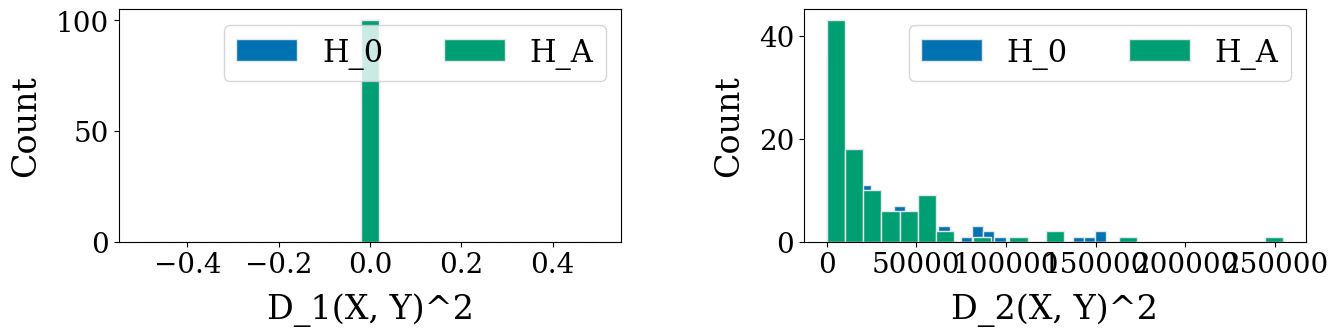

In [149]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].hist(MMD_1[:,0], bins=25, label='H_0',edgecolor='#E6E6E6')
ax[0].hist(MMD_1[:,1], bins=25, label='H_A',edgecolor='#E6E6E6')

ax[0].legend(loc='upper right', ncol=2, fontsize=22)
ax[0].set_xlabel('D_1(X, Y)^2', labelpad=10)
ax[0].set_ylabel('Count', labelpad=10)

ax[1].hist(MMD_2[:,0], bins=25, label='H_0', edgecolor='#E6E6E6')
ax[1].hist(MMD_2[:,1], bins=25, label='H_A', edgecolor='#E6E6E6')

ax[1].legend(loc='upper right', ncol=2, fontsize=22)
ax[1].set_xlabel('D_2(X, Y)^2', labelpad=10)
ax[1].set_ylabel('Count', labelpad=10)

plt.tight_layout(pad=3.0)
# plt.savefig('MMD_binary_tex.pdf',bbox_inches='tight')
plt.show()

In [19]:
MMD_1

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.

### Train first level

In [23]:
train_X = torch.tensor(X[:,:,0,:]).reshape([-1, L, D]).to(device)
train_Y = torch.tensor(X_n[:,:,0,:]).reshape([-1, L, D]).to(device)

train_X_dl = DataLoader(train_X, 128, shuffle=True)
train_Y_dl = DataLoader(train_Y, 128, shuffle=True)

In [24]:
train_Y.shape

torch.Size([500000, 3, 1])

In [25]:
lie_degree_1 = 4
num_samples_1 = 20
input_size = 1
add_time = False

pcf_level_1 = char_func_path(num_samples=num_samples_1, 
                              hidden_size=lie_degree_1, 
                              input_dim=input_size, 
                              add_time=add_time, 
                              include_initial = False)
pcf_level_1.to(device)

char_func_path(
  (unitary_development): development_layer(
    (projection): projection(
      (param_map): unitary()
    )
  )
)

In [26]:
iterations = 2000

char_optimizer = torch.optim.Adam(
        pcf_level_1.parameters(), betas=(0, 0.9), lr=0.002)

print('start opitmize charateristics function')
pcf_level_1.train()
for i in tqdm(range(iterations)):
    X_ = next(iter(train_X_dl))
    Y_ = next(iter(train_Y_dl))
    char_optimizer.zero_grad()
    char_loss = - pcf_level_1.distance_measure(
            X_, Y_, Lambda=0)
    if i%100 == 0:
        print("Iteration {} :".format(i), " loss = {}".format(-char_loss))
    char_loss.backward()
    char_optimizer.step()

start opitmize charateristics function


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0 :  loss = 0.00019097000767942518
Iteration 100 :  loss = 0.011122475378215313
Iteration 200 :  loss = 0.0008812019950710237
Iteration 300 :  loss = 0.011186576448380947
Iteration 400 :  loss = 0.004297185223549604
Iteration 500 :  loss = 0.001010038424283266
Iteration 600 :  loss = 0.0006641546497121453
Iteration 700 :  loss = 0.014417760074138641
Iteration 800 :  loss = 5.305147597264859e-14
Iteration 900 :  loss = 0.0004403514903970063
Iteration 1000 :  loss = 0.004441100172698498
Iteration 1100 :  loss = 0.02332552708685398
Iteration 1200 :  loss = 0.0006138706230558455
Iteration 1300 :  loss = 0.0001684476446826011
Iteration 1400 :  loss = 0.0016673080390319228
Iteration 1500 :  loss = 6.60986564961219e-14
Iteration 1600 :  loss = 0.0008758321637287736
Iteration 1700 :  loss = 0.015154204331338406
Iteration 1800 :  loss = 0.00025485194055363536
Iteration 1900 :  loss = 0.004349355585873127


In [31]:
for i in tqdm(range(repeats)):
    x0 = torch.tensor(X[i, :, 0, :, :], dtype=torch.float64).to(device)     # X of shape (repeats,n_samples,2,L,D)
    x0_ = torch.tensor(X[i, :, 1, :, :], dtype=torch.float64).to(device)    # independent copy of X
    xn = torch.tensor(X_n[i, :, 0, :, :], dtype=torch.float64).to(device)
    xn_ = torch.tensor(X_n[i, :, 1, :, :], dtype=torch.float64).to(device)  # independent copy of X_n
    
    order_1_expected_dev_x0 = pcf_level_1.unitary_development(x0).mean(0)
    order_1_expected_dev_x0_ = pcf_level_1.unitary_development(x0_).mean(0)
    order_1_expected_dev_xn = pcf_level_1.unitary_development(xn).mean(0)
#     order_2_expected_dev_xn_ = pcf_level_2.unitary_development(expected_dev_xn_).reshape([500, -1, 4, 4]).mean(0)
    
    MMD_1[i,0] = HS_norm(order_1_expected_dev_x0_-order_1_expected_dev_x0,
                        order_1_expected_dev_x0_-order_1_expected_dev_x0)
    MMD_1[i,1] = HS_norm(order_1_expected_dev_xn-order_1_expected_dev_x0,
                        order_1_expected_dev_xn-order_1_expected_dev_x0)

  0%|          | 0/1000 [00:00<?, ?it/s]

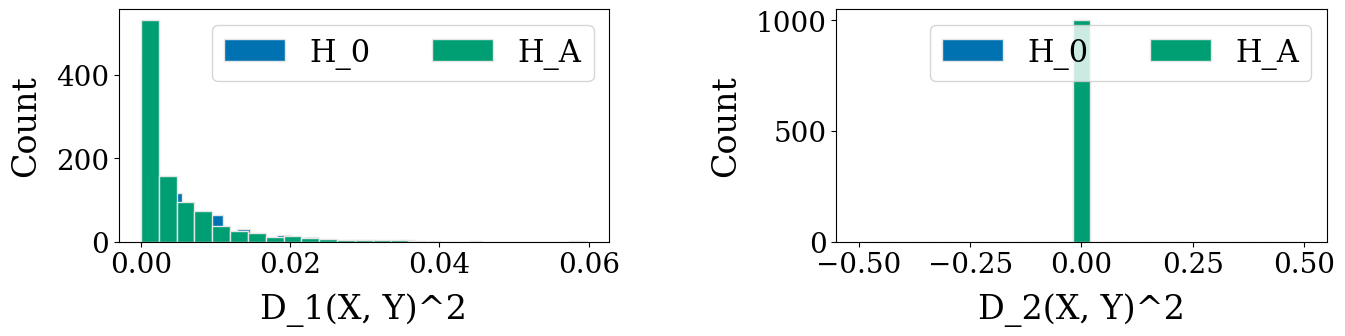

In [32]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].hist(MMD_1[:,0], bins=25, label='H_0',edgecolor='#E6E6E6')
ax[0].hist(MMD_1[:,1], bins=25, label='H_A',edgecolor='#E6E6E6')

ax[0].legend(loc='upper right', ncol=2, fontsize=22)
ax[0].set_xlabel('D_1(X, Y)^2', labelpad=10)
ax[0].set_ylabel('Count', labelpad=10)

ax[1].hist(MMD_2[:,0], bins=25, label='H_0', edgecolor='#E6E6E6')
ax[1].hist(MMD_2[:,1], bins=25, label='H_A', edgecolor='#E6E6E6')

ax[1].legend(loc='upper right', ncol=2, fontsize=22)
ax[1].set_xlabel('D_2(X, Y)^2', labelpad=10)
ax[1].set_ylabel('Count', labelpad=10)

plt.tight_layout(pad=3.0)
# plt.savefig('MMD_binary_tex.pdf',bbox_inches='tight')
plt.show()